####  Estudante: João Victor Soares de Almeida

In [1]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
import scipy.signal as signal
import numpy as np

from IPython.display import Audio, display, HTML
from ipywidgets import interact

from scipy.io import wavfile
import requests
from io import BytesIO

%matplotlib inline
matplotlib.rcParams['animation.writer'] = 'avconv'
matplotlib.rcParams['figure.figsize'] = "8,3"

# workaround function for strange interact implementation
def showInInteract():
    import inspect
    for i in range(5):
        if 'interaction.py' in inspect.stack()[i][1]: plt.show()

### Parte I

# Série de Fourier e Aproximação Harmônica

A série de Fourier toma um sinal periódico $ x (t) $ e descreve-o como uma soma de ondas senoidais e cossenoicas.Observando que seno e cosseno são funções periódicas, fica claro que $ x (t) $ também é uma função periódica. 

Matematicamente, a série de Fourier é descrita a seguir. Seja $ x (t) $ uma função periódica com o período $ T $, ou seja,

$$x(t)=x(t+nT), n\in\mathbb{Z}.$$ 


Então, podemos escrever $ x (t) $ como uma série de Fourier por

$$x(t)=\frac{a_0}{2}+\sum_{n=1}^{\infty}a_n\cos(2\pi \frac{nt}{T})+b_n\sin(2\pi\frac{nt}{T}),$$

onde $ a_n $ e $ b_n $ são os coeficientes da série de Fourier. Eles podem ser calculados por
$$\begin{align}a_n&=\frac{2}{T}\int_0^Tx(t)\cos(2\pi \frac{nt}{T})dt\\
b_n&=\frac{2}{T}\int_0^Tx(t)\sin(2\pi \frac{nt}{T})dt\end{align}.$$

Note que para uma função com período $ T $, as freqüências dos senos e co-senos são $ \frac {1} {T}, \frac {2} {T}, \frac {3} {T}, \dots $ , ou seja, são múltiplos da frequência fundamental $ \frac {1} {T} $, que é a duração do período inverso da função. Portanto, a frequência $ \frac {n} {T} $ é chamada de $ n $ th * harmônica *. O nome * harmônico * deriva do fato de que as freqüências do ouvido humano com razões inteiras soam "agradáveis", e as freqüências são todos múltiplos inteiros da freqüência fundamental.

Vamos verificar o cálculo dos coeficientes de Fourier e a reconstrução da função numericamente. Primeiro, definimos algumas funções com o período $ T = 1 $ que queremos expandir para uma série de Fourier:

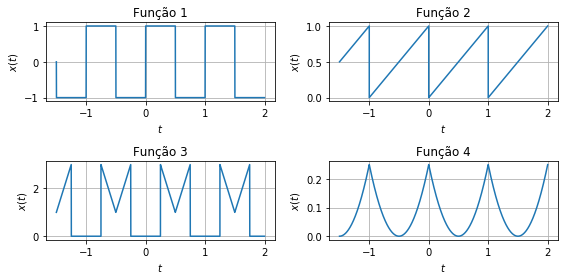

In [2]:
Fs = 10000
func1 = lambda t: (abs((t%1)-0.25) < 0.25).astype(float) - (abs((t%1)-0.75) < 0.25).astype(float)
func2 = lambda t: t % 1
func3 = lambda t: (abs((t%1)-0.5) < 0.25).astype(float) + 8*(abs((t%1)-0.5)) * (abs((t%1)-0.5)<0.25)
func4 = lambda t: ((t%1)-0.5)**2
t = np.arange(-1.5, 2, 1/Fs)
plt.figure(figsize=(8,4))
plt.subplot(221); plt.plot(t, func1(t))
plt.xlabel('$t$'); plt.ylabel('$x(t)$'); plt.grid(True); plt.ylim((-1.1, 1.1)); plt.title("Função 1")
plt.subplot(222); plt.plot(t, func2(t))
plt.xlabel('$t$'); plt.ylabel('$x(t)$'); plt.grid(True); plt.title("Função 2")
plt.subplot(223); plt.plot(t, func3(t))
plt.xlabel('$t$'); plt.ylabel('$x(t)$'); plt.grid(True); plt.title("Função 3")
plt.subplot(224); plt.plot(t, func4(t))
plt.xlabel('$t$'); plt.ylabel('$x(t)$'); plt.grid(True); plt.title("Função 4")
plt.tight_layout()


Agora, vamos escrever uma função `fourierSeries` que realiza o cálculo dos coeficientes da série de Fourier:

In [3]:
def fourierSeries(period, N):
    """Calcula os coeficientes da série de Fourier até o enésimo harmônico"""
    result = []
    T = len(period)
    t = np.arange(T)
    for n in range(N+1):
        an = 2/T*(period * np.cos(2*np.pi*n*t/T)).sum()
        bn = 2/T*(period * np.sin(2*np.pi*n*t/T)).sum()
        result.append((an, bn))
    return np.array(result)

E usá-lo para calcular os coeficientes até a 20ª ordem para a primeira função:

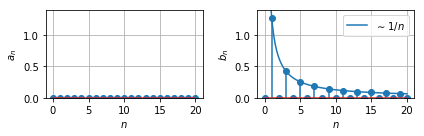

In [4]:
t_period = np.arange(0, 1, 1/Fs)
F = fourierSeries(func1(t_period), 20)
plt.figure(figsize=(6,2))
plt.subplot(121); plt.stem(F[:,0])
plt.grid(True); plt.xlabel('$n$'); plt.ylabel('$a_n$'); plt.ylim((0,1.4))
plt.subplot(122); plt.stem(F[:,1])
plt.grid(True); plt.xlabel('$n$'); plt.ylabel('$b_n$'); plt.ylim((0,1.4))
n = np.linspace(0.1,20,100);plt.plot(n, 4/(np.pi*n), label=r'$\sim 1/n$'); plt.legend(fontsize=10)
plt.tight_layout()

Vamos agora olhar para a reconstrução do sinal, ou seja, calculamos $ x (t) $ de seus coeficientes da série de Fourier até uma determinada ordem. Nós escrevemos uma função `reconstruct` para fazer isso por nós:

In [5]:
def reconstruct(P, anbn):
    result = 0
    t = np.arange(P)
    for n, (a, b) in enumerate(anbn):
        if n == 0:
            a = a/2
        result = result + a*np.cos(2*np.pi*n*t/P) + b * np.sin(2*np.pi*n*t/P)
    return result

Vamos dar uma olhada no sinal reconstruído para nossa função retangular até o 20º harmônico:

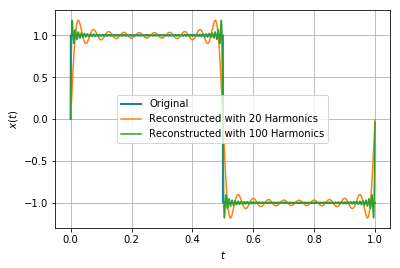

In [6]:
F = fourierSeries(func1(t_period), 100)
plt.plot(t_period, func1(t_period), label='Original', lw=2)
plt.plot(t_period, reconstruct(len(t_period), F[:20,:]), label='Reconstructed with 20 Harmonics');
plt.plot(t_period, reconstruct(len(t_period), F[:100,:]), label='Reconstructed with 100 Harmonics');
plt.grid(True); plt.ylabel('$x(t)$'); plt.xlabel('$t$');
plt.legend(fontsize=10);

Como podemos ver, o sinal reconstruído segue aproximadamente o original, e quanto mais harmônicos forem usados, melhor. No entanto, vemos também que, especialmente na região do salto em 𝑡 = 0,5, o sinal reconstruído não é exato. Em vez disso, o sinal reconstruído flutua significativamente nessa posição. Este fenómeno chama-se Gibbs Fenonenom e descreve o facto de a série de Fourier ter grandes oscilações em torno das descontinuidades do salto:

In [23]:
def showHarmonics(period, N):
    """Calculate the Fourier Series up to N harmonics, and show the reconstructed signal."""
    F = fourierSeries(period, N+1)
    plt.gcf().clear()
    plt.subplot(231); plt.stem(F[:,0])
    plt.xlim((0,20)); Vi = F.min(); Va = F.max(); plt.ylim((Vi,Va)); plt.ylabel('$a_n$')
    plt.subplot(234); plt.stem(F[:,1])
    plt.xlim((0,20)); plt.ylim((Vi,Va)); plt.xlabel('Harmonic'); plt.ylabel('$b_n$')
    plt.subplot(132)
    T = len(period)
    t = np.arange(T)/T
    result = 0
    for n, (an, bn) in enumerate(F):
        if n == 0:
            an = an/2
        cos_part = an*np.cos(2*np.pi*n*t)
        sin_part = bn*np.sin(2*np.pi*n*t)
        plt.plot(t, cos_part)
        plt.plot(t, sin_part)
        result = result + cos_part + sin_part
    plt.grid(True); plt.ylabel(r'$a_n \sin(2\pi n t), b_n\cos(2\pi nt)$'); plt.xlabel('$t$');
    plt.text(0.5, 0.8*abs(F[1:,:]).max(), 'N=%d' % N, bbox=dict(facecolor='white'))
    plt.subplot(133)
    t2 = np.arange(2*T)/T
    plt.plot(t2, np.tile(period, 2))
    plt.plot(t2, np.tile(result, 2))
    plt.grid(True); plt.ylabel(r'$x(t), r_N(t)$'); plt.xlabel('$t$');
    plt.ylim((period.min()-0.4, period.max()+0.4))
    plt.tight_layout()
    showInInteract()

Primeiro, vemos novamente a função retangular. Com o aumento do número de harmônicos, vemos que o rect é aproximado melhor. No entanto, vemos também que a quantidade de overshooting na descontinuidade do salto permanece constante, independente do número de harmônicos.

In [24]:
period = func1(np.arange(0, 1, 1/Fs))
interact(lambda N: showHarmonics(period, N), N=(1, 20));

interactive(children=(IntSlider(value=10, description='N', max=20, min=1), Output()), _dom_classes=('widget-in…

Em seguida é a função de rampa linear periódica. Novamente, vemos que a quantidade de overshooting na descontinuidade é independente do número de harmônicos. No entanto, a duração das oscilações torna-se menor e, em geral, a aproximação torna-se melhor com mais harmônicos. Além disso, com exceção do componente DC $ a_0 $, todos os coeficientes $ a_n = 0 $. Isto é novamente devido ao fato de que a função é ímpar, ou seja, temos $ x (t) = 1-x (-t) $. Portanto, apenas os componentes da onda senoidal são diferentes de zero.

In [461]:
period = func2(np.arange(0, 1, 1/Fs))
interact(lambda N: showHarmonics(period, N), N=(1, 20));

A terceira função parece mais complicada, pois tem mais saltos e é, em geral, mais irregular que as funções anteriores. De fato, há uma quantidade significativa de overshooting na parte inferior do gráfico, que só muito lentamente diminui com mais harmônicos. Isso vem da alta quantidade de descontinuidades da função. A função é uma função par, ou seja, $ x (t) = x (-t) $. Portanto, todos os $ b_n = 0 $, que correspondem à contribuição das ondas senoidais. Em vez disso, apenas as ondas cosseno, que são funções pares, compõem a série geral de Fourier.

In [25]:
period = func3(np.arange(0, 1, 1/Fs))
interact(lambda N: showHarmonics(period, N), N=(1, 20));

interactive(children=(IntSlider(value=10, description='N', max=20, min=1), Output()), _dom_classes=('widget-in…

Eventualmente, vamos dar uma olhada na função periódica da parábola. Primeiro, reconhecemos que a função é bem aproximada, com pouquíssimos harmônicos. Podemos explicar isso pela suavidade geral da função sem descontinuidades. Além disso, novamente identificamos que $ b_n = 0 $, uma vez que $ x (t) $ é uma função par, ou seja, $ x (t) = x (-t) $

In [26]:
period = func4(np.arange(0, 1, 1/Fs))
interact(lambda N: showHarmonics(period, N), N=(1, 20));

interactive(children=(IntSlider(value=10, description='N', max=20, min=1), Output()), _dom_classes=('widget-in…

## Conclusões 3.3 Haykin
Série de Fourier é uma forma de série trigonométrica usada para representar funções infinitas e periódicas complexas dos processos físicos, na forma de funções trigonométricas simples de senos e cossenos. A Série de Fourie(FS) se aplica a sinais periódicos de tempo contínuo. Ela representa o sinal como uma soma ponderada de um número infinito de senóides complexas de tempo contínuo cujas frequências são múltiplos inteiros da frequência fundamental do sinal.

##### A forma geral da série é:

> - $T(t)=\frac{a_0}{2} + \sum_{n=1}^{\infty}\left[a_n\cdot\cos\left(\frac{n \pi t}{L}\right) + b_n \cdot \operatorname{sen}\left(\frac{n \pi t}{L}\right)\right]$

Onde os termos **a0, an e bn** são números que variam de acordo com a função que será representada.

Seja $f$ uma função periódica de período $2L$, ou seja $f(t + 2L) = f(t) $ para todo $t$, a qual satisfaz às seguintes condições:

>- A função é Função injectiva (de um para um), e função contínua|contínua exceto em um número finito de descontinuidade ordinárias dentro do período 2L, ou seja, $x(t)$ é limitado;

>- A função tem um número finito de máximos e mínimos locais dentro do período 2L,
>- A função é absolutamente integrável, ou seja, a integral $\int_{0}^{2L} |f(t)|\,dt$ converge.

Se um sinal $x(t)$ stisfizer as condições de **Direchlet** e não for contínuo, então a representação por FS convergirá para o ponto médio de $x(t)$ em cada descontinuidade.




Então define-se a Série de Fourier da função $f$ como a série trigonométrica dada pelos coeficientes:

$a_0=\frac{1}{L} \int_{c}^{c+2L} f(t)\,dt$, $a_n=\frac{1}{L} \int_{c}^{c+2L} f(t) \cos\left(\frac{n \pi t}{L}\right)\,dt$, $n\geq1$ e $b_n=\frac{1}{L} \int_{c}^{c+2L} f(t) \,\operatorname{sen}\left(\frac{n \pi t}{L}\right)\,dt$ ,  $n\geq1$

Os coeficientes $an,bn,a_0$ são conhecidos como coeficientes de Fourier.


##### Forma Harmônica:

Aplicando a identidade na forma harmônica, tem-se que:

> - $f(t) = A_0 + \sum_{n=1}^{\infty} [A_n\cos(\theta_n)\cos(w_nt) + A_n\sin(\theta_n)\sin(w_nt)]$

Comparando os termos com os da representação trigonométrica, tem-se que:

> - $A_0 =  \frac{a_0}{2}, a_n = A_n\cos(\theta_n)$ e $b_n = A_n\sin(\theta_n)$

#### Inferências
>- Para funções pares , isto é, $x (t) = x (- t)$, a série de Fourier consiste apenas em cossenos . Para funções ímpares , isto é, $x (t) = - x (- t)$, a série de Fourier consiste apenas em senos.

>- Funções suaves precisam de menos harmônicos para serem descritas com precisão pela série de Fourier.

#### Conclusão
Na implementação feita acima, pudemos compreender graficamente e através do algoritmo que a Série de Fourier nos permite modelar qualquer sinal periódico arbitrário com uma combinação de senos e cossenos. Nota-se nitidamente que o sinal $x(t)$ aproximado pela série de Fourier vai se tornando cada vez mais próximo do original quando a quantidade de $N$ vai aumentando.



### Parte II


In [7]:
def fourierSeries(period, N):
    """Calculate the Fourier series coefficients up to the Nth harmonic"""
    result = []
    T = len(period)
    t = np.arange(T)
    for n in range(N+1):
        an = 2/T*(period * np.cos(2*np.pi*n*t/T)).sum()
        bn = 2/T*(period * np.sin(2*np.pi*n*t/T)).sum()
        result.append((an, bn))
    return np.array(result)

In [8]:
def reconstruct(P, anbn):
    """Sum up sines and cosines according to the coefficients to 
    produce a reconstruction of the original waveform"""
    result = 0
    t = np.arange(P)
    for n, (a, b) in enumerate(anbn):
        if n == 0:
            a = a/2
        result = result + a*np.cos(2*np.pi*n*t/P) + b * np.sin(2*np.pi*n*t/P)
    return result

Primeiro de tudo, vamos carregar três sons de saxofone da base:

In [13]:
def loadSound(url):
    R = requests.get(url)
    rate, data = wavfile.read(BytesIO(R.content))
    data = data * 1.0 / (abs(data).max())
    if len(data.shape) > 1:  # for stereo data, use only first channel
        data = data[:,0]
    return data, rate

# the URLs of the wav files
urls = [
       "http://cd.textfiles.com/sbsw/INSTRMNT/TENORSA.WAV",
    "http://ecee.colorado.edu/~mathys/ecen1200/hwcl09/sound1.wav"]
sounds = []
for url in urls:
    sound, rate = loadSound(url)
    sounds.append((sound, rate))

In [14]:
# Utility function two display two audios side by side in the notebook
def audioSideBySide(name1, audio1, name2, audio2):
    text = '<table class="audiotable"><tr><td>%s</td><td>%s</td></tr><tr><td>%s</td><td>%s</td></tr></table>' % (name1, name2, audio1._repr_html_(), audio2._repr_html_())
    display(HTML(text))

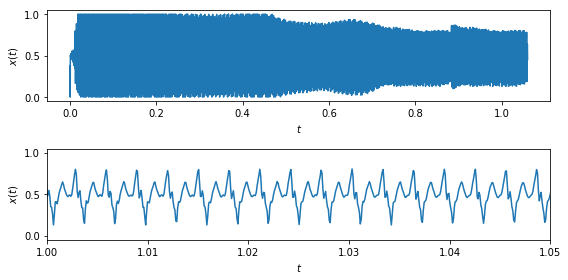

In [15]:
t = np.arange(len(sounds[0][0])) / sounds[0][1]
plt.figure(figsize=(8,4))
plt.subplot(211)
plt.plot(t, sounds[0][0])
plt.xlabel('$t$'); plt.ylabel('$x(t)$')
plt.subplot(212)
plt.plot(t, sounds[0][0])
plt.xlim((1, 1.05))
plt.xlabel('$t$'); plt.ylabel('$x(t)$')
plt.tight_layout()

Original,Extracted period


Original,Extracted period


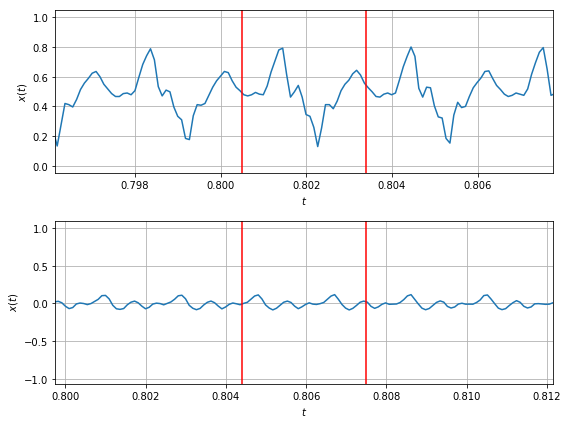

In [16]:
def extractPeriod(data, rate, t_start, t_end):
    t = np.arange(0,len(data))/rate
    plt.plot(t, data)
    duration = t_end - t_start
    plt.xlim((t_start-1.5*duration, t_end+1.5*duration))
    plt.grid(True)
    plt.xlabel('$t$'); plt.ylabel('$x(t)$');

    plt.axvline(t_start, color='red')
    plt.axvline(t_end, color='red')

    sample_start = int(t_start * rate)
    sample_end = int(t_end*rate)

    period = data[sample_start:sample_end]
    audioSideBySide("Original", Audio(data=data,rate=rate), 
                    "Extracted period", Audio(np.tile(period, int(1/duration)), rate=rate))
    return period, rate

plt.figure(figsize=(8,6))
periods = []
rates = []
# The manually found start and end time of one period of the signal
periodBounds = [(0.8005,0.8034),
                (0.8044,0.8075),
                (0.20555,0.2132)]
for n, (S, P) in enumerate(zip(sounds, periodBounds)):
    plt.subplot(len(sounds), 1, n+1)
    period, rate = extractPeriod(S[0], S[1], P[0], P[1])
    periods.append(period); rates.append(rate)
plt.tight_layout()

In [18]:
def approximateUpToNthHarmonic(period, rate, N):
    t = np.arange(len(period)) / rate
    duration = t.max()
    F = fourierSeries(period, N)
    powers = np.sqrt(np.sum(F**2, axis=1))
    reconstructed = reconstruct(len(period), F)
    
    plt.figure(figsize=(8,2))
    plt.subplot(121)
    plt.plot(t*1000, period, label='Original') 
    plt.plot(t*1000, reconstructed, label='Reconstructed')
    plt.xlabel('$t$ [ms]'); plt.ylabel('$x(t)$'); plt.grid(True)
    plt.subplot(122)
    powers[0]=0
    plt.stem(powers)
    plt.xlim((0,20))
    plt.ylabel('Harmonic power'); plt.xlabel('Harmonic index'); plt.grid(True)
    plt.tight_layout()
    
    audioSideBySide("Original", Audio(data=np.tile(period, int(0.7/duration)), rate=rate), 
                    "Reconstructed up to %d harmonics" % N, Audio(data=np.tile(reconstructed, int(0.7/duration)), rate=rate))

Original,Reconstructed up to 1 harmonics


Original,Reconstructed up to 1 harmonics


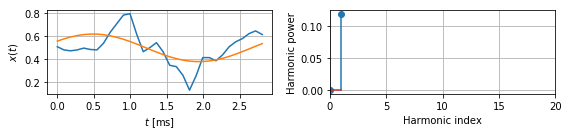

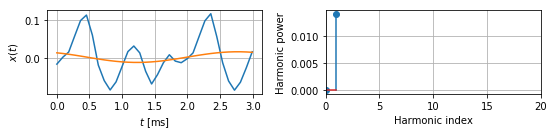

In [19]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 1)

Original,Reconstructed up to 2 harmonics


Original,Reconstructed up to 2 harmonics


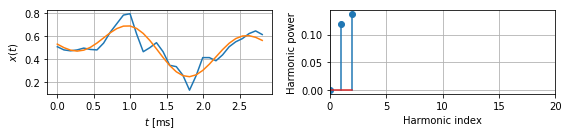

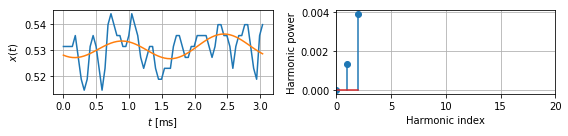

In [29]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 2)

Original,Reconstructed up to 10 harmonics


Original,Reconstructed up to 10 harmonics


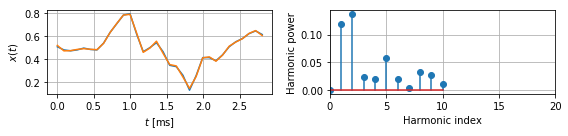

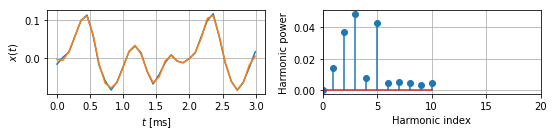

In [20]:
for P, R in zip(periods, rates):
    approximateUpToNthHarmonic(P, R, 10)

Original,Reconstructed up to 20 harmonics


Original,Reconstructed up to 20 harmonics


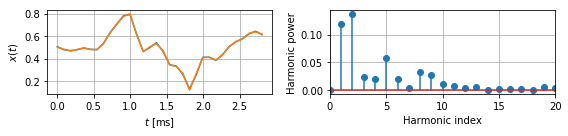

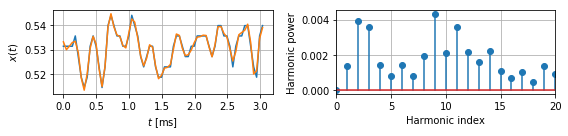

In [30]:
for P, R in list(zip(periods, rates)):
    approximateUpToNthHarmonic(P, R, 20)

Original,Reconstructed up to 30 harmonics


Original,Reconstructed up to 40 harmonics


Original,Reconstructed up to 30 harmonics


Original,Reconstructed up to 40 harmonics


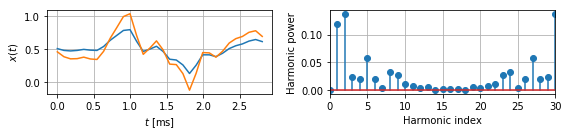

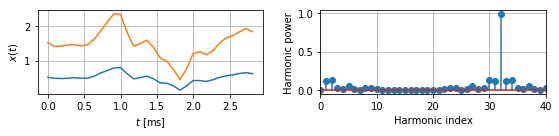

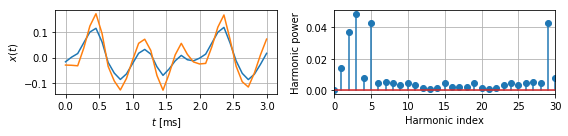

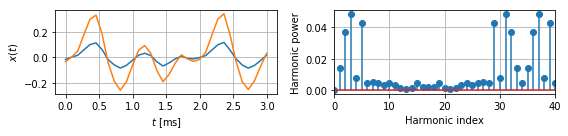

In [21]:
for P, R in list(zip(periods, rates)):
    approximateUpToNthHarmonic(P, R, 30)
    plt.xlim(0,30)
    approximateUpToNthHarmonic(P, R, 40)
    plt.xlim(0,40)
    

####  Conclusões para PARTE II 

No script acima utilizando um aúdio escolhido pelo autor que foi o do saxofone e o outro som escolhido por eu, o som de uma impressora. No mais, chegamos a conclusão que quando um instrumento musical produz uma determinada nota, ele produz **não apenas o som da freqüência fundamental, que dá a qualidade de tonalidade, mas também o de freqüências harmônicas múltiplas da fundamental**. Se não fosse assim, não haveria diferença entre o som de instrumentos diferentes. É a proporção dos harmônicos presentes no som produzido por cada tipo ou qualidade de instrumento que os diferencia, dando-lhes sua qualidade de timbre.

A mesma nota tocada em instrumentos diferentes soará com timbres diferentes pelo fato do som gerado por cada instrumento conter os harmônicos do tom fundamental em proporções diferentes. Essas proporções são características de cada tipo de instrumento, e, para o ouvido mais acurado, características de cada modelo ou exemplar de instrumento.

O som produzido por um instrumento é uma série de Fourier onde a intensidade sonora de cada freqüência harmônica componente é determinada pelas características do instrumento. Por exemplo, o som produzido por instrumentos de corda geralmente possue todos os múltiplos da freqüência fundamental como componentes, enquanto alguns instrumentos de sopro, que possuem tubo de ressonância aberto num extremo e fechado no outro, produzem som que contém apenas os harmônicos ímpares $b_n$.



Matematicamente, a série de Fourier é descrita a seguir. Seja $ x (t) $ uma função periódica com o período $ T $, ou seja,

$$x(t)=x(t+nT), n\in\mathbb{Z}.$$ 


Então, podemos escrever $ x (t) $ como uma série de Fourier por

$$x(t)=\frac{a_0}{2}+\sum_{n=1}^{\infty}a_n\cos(2\pi \frac{nt}{T})+b_n\sin(2\pi\frac{nt}{T}),$$

onde $ a_n $ e $ b_n $ são os coeficientes da série de Fourier. Eles podem ser calculados por
$$\begin{align}a_n&=\frac{2}{T}\int_0^Tx(t)\cos(2\pi \frac{nt}{T})dt \\
b_n&=\frac{2}{T}\int_0^Tx(t)\sin(2\pi \frac{nt}{T})dt\end{align}.$$

- a_n = (COMPONENTE PAR)
- b_n= (COMPONENTE ÍMPAR)